In [ ]:
import os
import sys
import json
from pathlib import Path
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps, ImageFilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


Python version: 3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]
TensorFlow version: 2.20.0
NumPy version: 2.2.6


In [ ]:

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x
def build_unet_model(input_shape=(256, 256, 2)):
   inputs = layers.Input(shape=input_shape)
   f1, p1 = downsample_block(inputs, 32)
   f2, p2 = downsample_block(p1, 64)
   bottleneck = double_conv_block(p2, 128)
   u3 = upsample_block(bottleneck, f2, 64)
   u4 = upsample_block(u3, f1, 32)
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u4)
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
IMG_SIZE = 256 
VAL_FRAC = 0.15
EPOCHS = 10
BATCH_SIZE = 8
OUT_DIR = "./images_gray"
OUT_NPZ = os.path.join(OUT_DIR, "cell_segmentation.npz")

for d in [OUT_DIR, f"{OUT_DIR}/models", f"{OUT_DIR}/plots", f"{OUT_DIR}/reports"]:
    os.makedirs(d, exist_ok=True)

print(f"Output directory: {os.path.abspath(OUT_DIR)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: 2 (grayscale + Sobel edge)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Python version: {sys.version.split()[0]}")

Output directory: /Users/lemon/Documents/Python/BME 4790/Project2/images_gray
Image size: 256x256
Input channels: 2 (grayscale + Sobel edge)
Batch size: 8
Python version: 3.11.5


In [ ]:
def process_image(im: Image.Image, target_size=(256, 256)) -> np.ndarray:
    im_gray = im.convert('L')
    im_gray = im_gray.resize(target_size)
    arr_gray = np.asarray(im_gray, dtype=np.float32) / 255.0
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
    from scipy.ndimage import convolve
    grad_x = convolve(arr_gray, sobel_x)
    grad_y = convolve(arr_gray, sobel_y)
    sobel_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    sobel_magnitude = sobel_magnitude / (sobel_magnitude.max() + 1e-8)
    arr_combined = np.stack([arr_gray, sobel_magnitude], axis=-1)
    return arr_combined

def process_mask(mask: Image.Image, target_size=(256, 256)) -> np.ndarray:
    mask_gray = mask.convert('L')
    mask_gray = mask_gray.resize(target_size)
    mask_array = np.asarray(mask_gray, dtype=np.float32) / 255.0
    mask_array = np.expand_dims(mask_array, axis=-1)
    return mask_array

def load_segmentation_data(dataset_path: Path):
    X_train, y_train = [], []
    X_test, y_test = [], []
    train_img_dir = dataset_path / "BCCD Dataset with mask" / "train" / "original"
    train_mask_dir = dataset_path / "BCCD Dataset with mask" / "train" / "mask"
    print(f"Loading training images from {train_img_dir}...")
    img_files = sorted(list(train_img_dir.glob("*.png")))
    for img_path in img_files:
        mask_path = train_mask_dir / img_path.name
        if mask_path.exists():
            with Image.open(img_path) as img, Image.open(mask_path) as mask:
                X_train.append(process_image(img))
                y_train.append(process_mask(mask))
    print(f"Loaded {len(X_train)} training samples")
    test_img_dir = dataset_path / "BCCD Dataset with mask" / "test" / "original"
    test_mask_dir = dataset_path / "BCCD Dataset with mask" / "test" / "mask"
    print(f"Loading test images from {test_img_dir}...")
    img_files = sorted(list(test_img_dir.glob("*.png")))
    for img_path in img_files:
        mask_path = test_mask_dir / img_path.name
        if mask_path.exists():
            with Image.open(img_path) as img, Image.open(mask_path) as mask:
                X_test.append(process_image(img))
                y_test.append(process_mask(mask))
    print(f"Loaded {len(X_test)} test samples")
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

def split_train_val(X_train, y_train, val_frac=0.15):
    val_size = int(len(X_train) * val_frac)
    indices = np.random.permutation(len(X_train))
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    X_train_new = X_train[train_indices]
    y_train_new = y_train[train_indices]
    return X_train_new, X_val, y_train_new, y_val

print("Data preparation functions loaded!")

Data preparation functions loaded!


In [ ]:
dataset_path = Path("./BCCD Dataset with mask")

Loading Local Dataset
✓ Dataset found at: /Users/lemon/Documents/Python/BME 4790/Project2/BCCD Dataset with mask
✓ Training images: 1063
✓ Test images: 146

Sample files:
  - 027ab174-e47a-44f8-b85b-372449eeb7d8.png
  - b1145408-feae-4637-b4cf-3e70b99cc62d.png
  - a11ed7d0-12f6-468f-abad-5cba7d968123.png

Dataset Ready!


In [ ]:
X_train, y_train, X_test, y_test = load_segmentation_data(Path("."))
X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, val_frac=VAL_FRAC)

np.savez_compressed(
    OUT_NPZ,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test
)
print(f"\nSaved processed data to: {os.path.abspath(OUT_NPZ)}")

Loading training images from BCCD Dataset with mask/train/original...
Loaded 1063 training samples
Loading test images from BCCD Dataset with mask/test/original...
Loaded 146 test samples

Dataset loaded:
X_train shape: (1063, 256, 256, 2)
y_train shape: (1063, 256, 256, 1)
X_test shape: (146, 256, 256, 2)
y_test shape: (146, 256, 256, 1)

After train/val split:
X_train shape: (904, 256, 256, 2)
y_train shape: (904, 256, 256, 1)
X_val shape: (159, 256, 256, 2)
y_val shape: (159, 256, 256, 1)

Saved processed data to: /Users/lemon/Documents/Python/BME 4790/Project2/images_gray/cell_segmentation.npz


In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=EPOCHS, batch_size=BATCH_SIZE):
    model.compile(
        optimizer="adam",
        loss="MSE",
        metrics=["accuracy"]
    )
    print(f"\nTraining {model_name}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/{model_name}_training.png", dpi=150, bbox_inches='tight')
    plt.show()
    return history

def evaluate_model(model, X_test, y_test, model_name):
    y_true = y_test
    y_pred = model.predict(X_test, verbose=0)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Test Accuracy: {acc:.4f}")
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/{model_name}_cm.png", dpi=150, bbox_inches='tight')
    plt.show()
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(f"\n{model_name} Classification Report:")
    print(report)
    with open(f"{OUT_DIR}/reports/{model_name}_report.txt", "w") as f:
        f.write(f"Test Accuracy: {acc:.4f}\n\n")
        f.write(report)
    return acc

def evaluate_segmentation_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test, verbose=0)
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    pixel_accuracy = np.mean(y_pred_binary == y_test)
    ious = []
    for i in range(len(y_test)):
        intersection = np.sum(y_pred_binary[i] * y_test[i])
        union = np.sum(y_pred_binary[i]) + np.sum(y_test[i]) - intersection
        iou = intersection / (union + 1e-8)
        ious.append(iou)
    iou = np.mean(ious)
    print(f"\n{model_name} Test Metrics:")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"IoU (Intersection over Union): {iou:.4f}")
    num_samples = min(6, len(X_test))
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(X_test[i, :, :, 0], cmap='gray')
        axes[i, 0].set_title('Input (Grayscale)')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(X_test[i, :, :, 1], cmap='gray')
        axes[i, 1].set_title('Input (Sobel)')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(y_test[i, :, :, 0], cmap='gray')
        axes[i, 2].set_title('Ground Truth')
        axes[i, 2].axis('off')
        axes[i, 3].imshow(y_pred_binary[i, :, :, 0], cmap='gray')
        axes[i, 3].set_title('Prediction')
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/{model_name}_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()
    return pixel_accuracy, iou

print("Training and evaluation functions loaded!")

Training and evaluation functions loaded!


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │     73,792 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     73,792 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │     18,464 │ conv2d_7[0][0]  

 Total params: 517,441 (1.97 MB)

 Trainable params: 517,441 (1.97 MB)

 Non-trainable params: 0 (0.00 B)


Training unet_segmentation...
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8642 - loss: 0.0434 - val_accuracy: 0.8917 - val_loss: 0.0202
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8990 - loss: 0.0154 - val_accuracy: 0.8980 - val_loss: 0.0147
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9015 - loss: 0.0131 - val_accuracy: 0.8995 - val_loss: 0.0131
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9029 - loss: 0.0117 - val_accuracy: 0.9016 - val_loss: 0.0115
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9032 - loss: 0.0113 - val_accuracy: 0.9020 - val_loss: 0.0110
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9037 - loss: 0.0106 - val_accuracy: 0.9020 - val_loss: 0.0110
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9040 - loss: 0.0103 - val_accuracy: 0.9024 - val_loss: 0.0105
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0

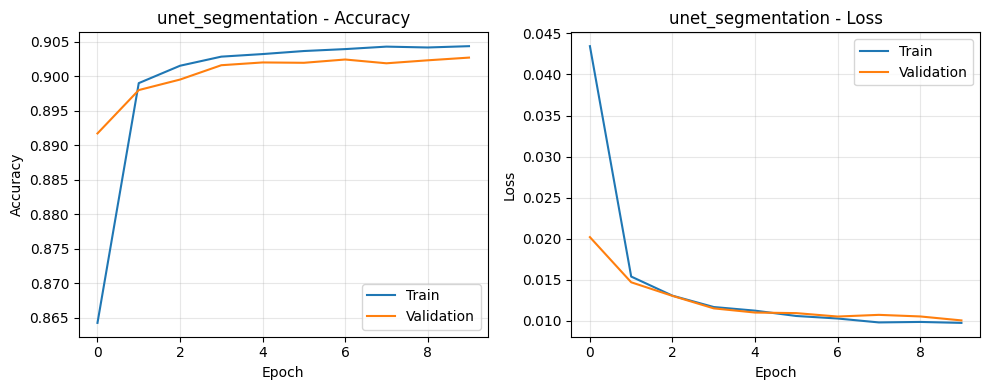


UNet model saved to: ./images_gray/models/unet_segmentation.keras


In [ ]:
unet_model = build_unet_model(input_shape=(256, 256, 2))
unet_model.summary()
unet_history = train_model(unet_model, X_train, y_train, X_val, y_val, "unet_segmentation")
unet_model.save(f"{OUT_DIR}/models/unet_segmentation.keras")
print(f"\nUNet model saved to: {OUT_DIR}/models/unet_segmentation.keras")


unet_segmentation Test Metrics:
Pixel Accuracy: 0.9013
IoU (Intersection over Union): 0.9005


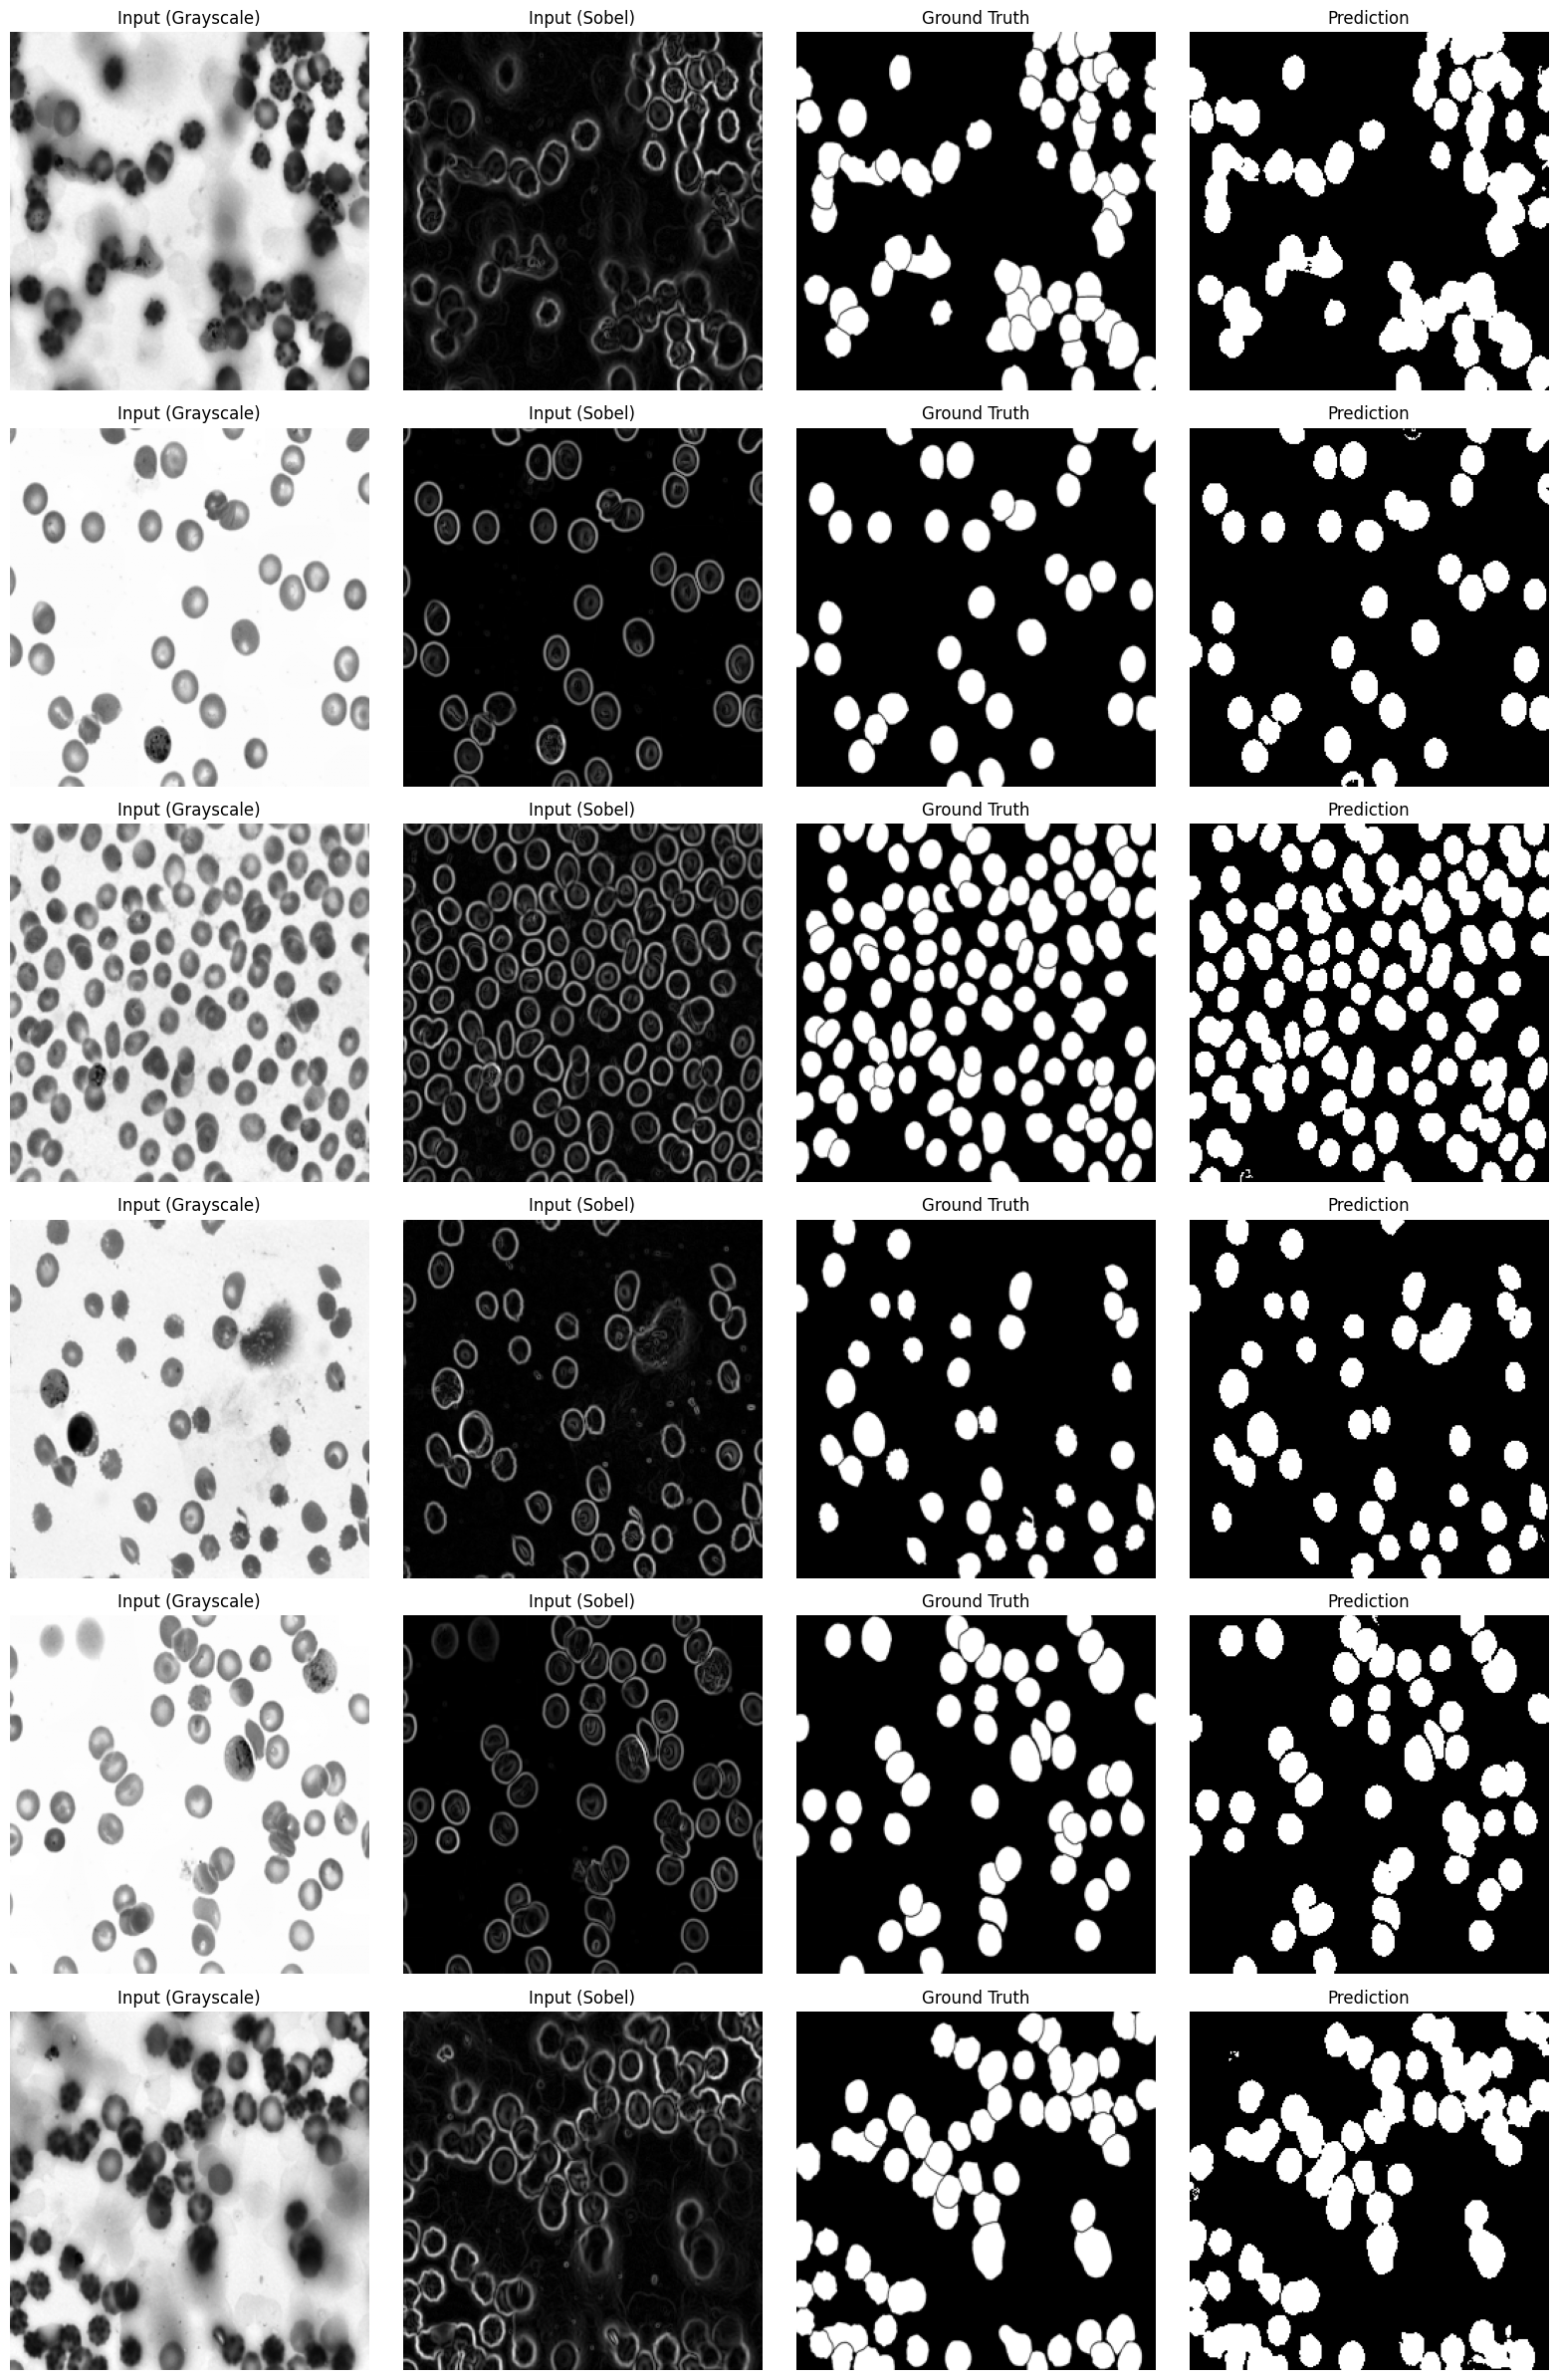

FINAL RESULTS:
  Pixel Accuracy: 0.9013


In [ ]:
pixel_acc, iou = evaluate_segmentation_model(unet_model, X_test, y_test, "unet_segmentation")

print(f"FINAL RESULTS:")
print(f"  Pixel Accuracy: {pixel_acc:.4f}")
print(f"  IoU Score: {iou:.4f}")